# Downloading and preliminary cleaning of Data from What Middletown Read
In this notebook, we'll use data from  [What Middletown Read](https://lib.bsu.edu/wmr/index.php) (hereafter WMR), a joint project of Ball State University Library and the Muncie, Indiana Public Library. WMR publishes late nineteenth- and early twentieth-century borrowing records from the Muncie Public Library, so we can see what books patrons were borrowing and look, for instance, for communities of readers clustered around certain books.

* WMR makes its data available for download in .csv format, so it's pretty straightforward to get the data we want. 
  - We'll also scrape a little bit of data that doesn't come with the downloadable .csvs using a Chrome browser extension called [Scraper](https://chrome.google.com/webstore/detail/scraper/mbigbapnjcgaffohmbkdlecaccepngjd). Getting this extra data will allow us to link back to the WMR site from our visualization, and will also allow us to get still more information from the site that's not included in the downloadable .csv files.
* We'll use OpenRefine to do one piece of data cleanup of the sort where OpenRefine really shines.

At that point, the exercise will branch, and you can choose the path you prefer:

* You can use Google Sheets to build your node and edge lists; or 
* You can work through a notebook that does the same thing in Python code.

## 1 - Searching *What Middletown Read*
Because WMR makes search results easily downloadable in .csv format, we can just use the site's search form to identify the records we're interested in and get (almost) everything we could want with the click of a button. 

For this walk-through, I'll be using results for a search for all books borrowed between July 1 and July 31, 1895. To reduce the number of results a bit, I've also limited my search to books with "Fiction" in the subject heading. You should feel free to experiment with different searches, though: the WMR advanced search form exposes a lot more options than I'm showing here, so you might find a line on some data that would be more interesting than my "people who borrowed fiction in July, 1895" group.

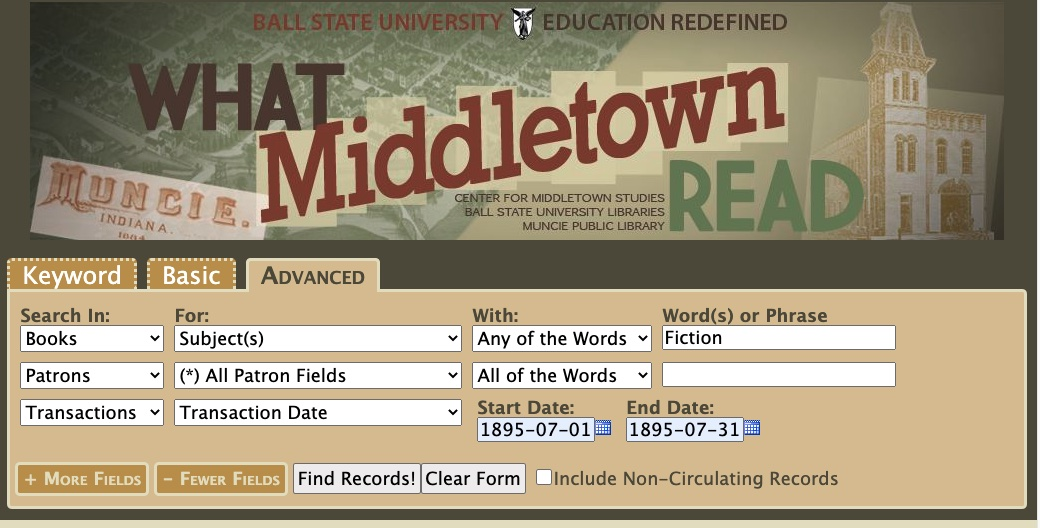

The results page presents us with three sections (Books, Patrons, and Transactions), all of which are toggled closed to start with.

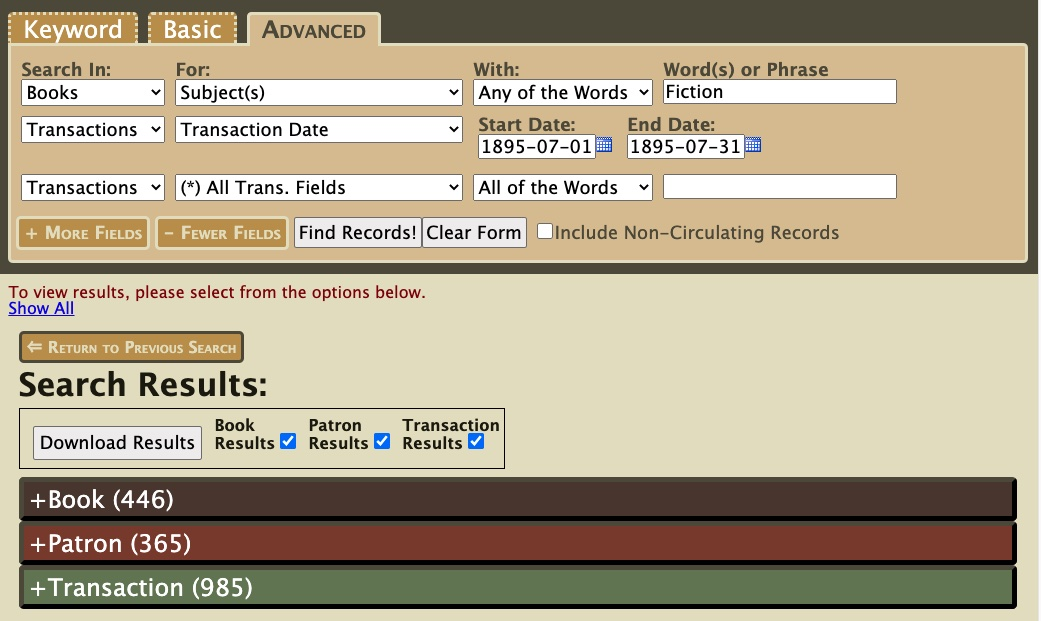

## 2 - Download results in .csv format and unzip compressed file
We'll have a look at those sections in the browser in a minute, but for now, let's download all of this information in .csv format. 

We can just leave all three boxes checked and click "Download Results." You'll end up with a .zip file with a title beginning `wmr_full_search_results_` followed by a time stamp—this can end up in your Downloads folder, or wherever else you choose. (For just this once, it doesn't matter where you put this folder, so long as you can find it again.) Find that folder on your hard drive, then double click it to decompress the .zip archive and—to make life easier later, delete the time stamp portion (your folder should end up being called `wmr_full_search_results`). 

We're going to end up doing a little bit of cleaning of one file in OpenRefine before uploading everything to Google Drive. Leave the window with your WMR results open, though, because we'll come back to it in the next notebook.

## 3 - A little bit of cleaning in OpenRefine
While the .csv files that we can download from WMR are pretty helpful, it will be useful to clean up the "Author" field in the `book.csv` file. It's not impossible to clean up that field either in Google Sheets or in Python code, by any means, but this kind of data cleaning is an area where OpenRefine really shines.

There can end up being a lot of individual steps in this process, and the precise steps you take will depend entirely on the data you're working with. If you're working through the same WMR records I'm using in this example, your best bet is probably to skim through my description of the steps I took, but, rather than recreating all of them, to use the file I produced at the end (which is in the `data_class` folder).

If you're working with your own data from WMR, you can probably follow most of the same steps I did here and get similar results. But if you run into a tricky bit in the data you happen to have, feel free to ask a question in Slack or jump back into Zoom and we'll figure it out.

Launch OpenRefine and visit [http://127.0.0.1:3333](http://127.0.0.1:3333) in your browser. Create a new project, and upload the `book.csv` file from your `wmr_full_search_results` folder. You'll need to set up the import to ignore the first line in the .csv file, and to use commas as the field delimiter.

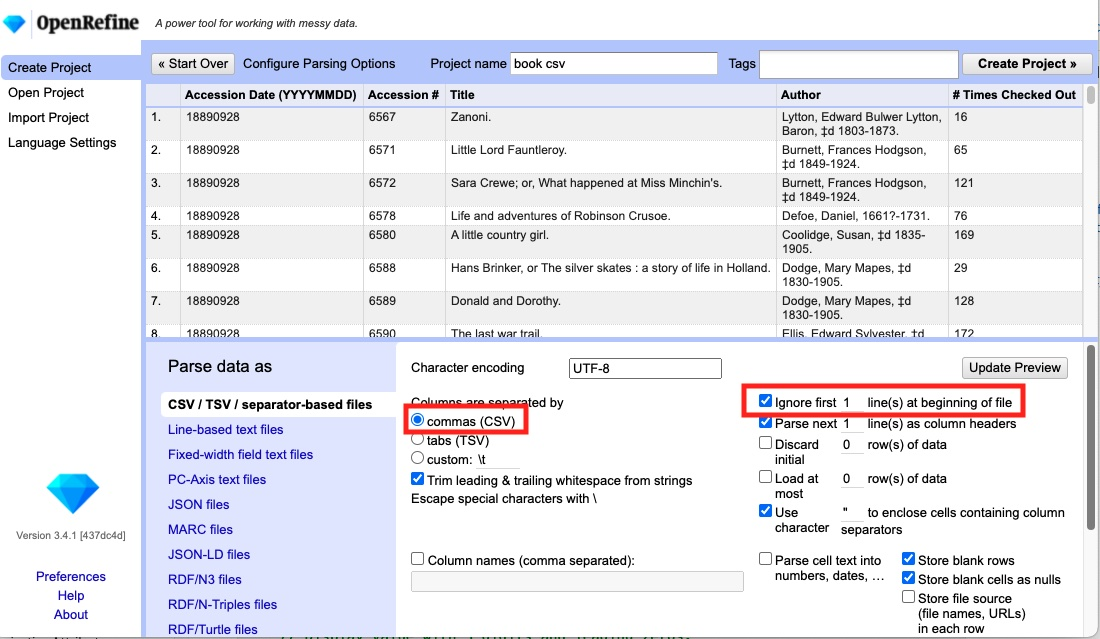

If you scroll through some rows, you'll see that the forms that authors' names take are varied: there are various ways of representing their dates (with and without a "‡" character, with expanded forms of the name in parentheses, etc.) I'd like to be able to use just the author's name as part of the label that will appear in the network visualizaiton, so I want to extract the name and leave the dates behind.

Rather than requiring us to figure out a single formula for fixing every possible problem we could run into throughout our data, OpenRefine gives us the means to solve the problem iteratively, and to see our results as we go.

There are any number of approaches we could take to this, and I'd encourage you to try out a few different strategies to see what you can figure out. I'll outline the steps I took so you can have a model to follow, if you'd like.

When the OpenRefine project has loaded, click on the triangle at the top of the `Author` column, then select "Edit column" and "Add a column based on this column. As we create this new column, we can take a first pass at fixing some of the most common problems that we see.

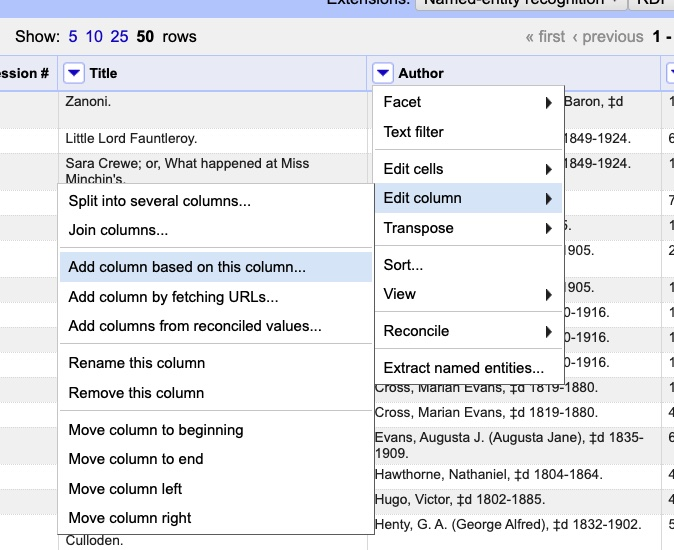

I opted to approach this problem in Python, since it's the language I know best. I had a strong hunch that I would end up using regular expressions, eventually (which allow you to search for *patterns* of text without knowing what *specific* text you're looking for. But I wanted to start simpler and see if I could begin by just eliminating the dates.

I used this formula:
```
if value.count(',') > 1 :
  return value[0:value.rfind(',')]
else :
  return value
```

The opening `if` condition counts how many commas appear in the `value` (`value` is OpenRefine's name for the contents of the cell we're transforming). If there is more than one comma, then we return a substring of the value that begins at index 0 (that is, the beginning of the string) and continues up to (but not including) the index of the right-most comma (`rfind()` searches the string from the right, rather than the left). 

If there is not more than one comma (as is the case with a field like `Newman, Mrs. (Mary)`), then the formula returns the original value without altering it.

This looked like it would work for a lot of my rows, so I clicked "OK" to see what I had. 

In order to get an overview of the values I'd just created, I clicked the triangle at the top of my new column and selected "Facet" and then "Text facet." 

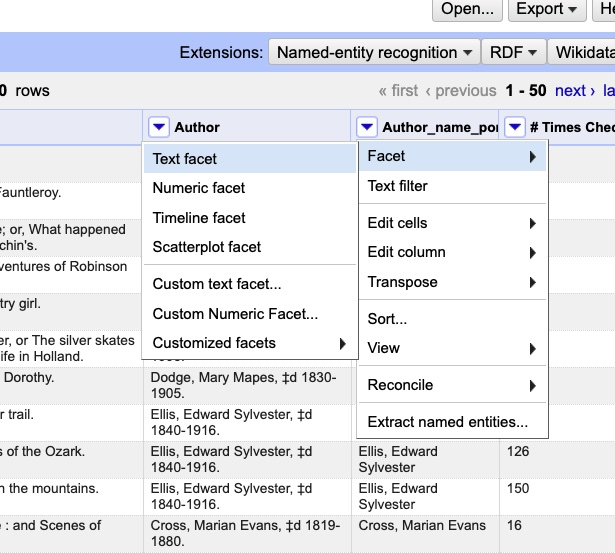

Looking through the values that appeared in the list of facets, it seemed clear that most of these names were now in a pretty simple, last name/first name format that would be pretty easy to rearrange. But I wanted to deal with the names that *didn't* fit that pattern, first. 

I had to start *somewhere*, so I started with one of the first patterns I noticed: some of the names had initials with a fuller form of the name in parentheses (with or without "‡q").

I clicked on the triangle at the top of the column again and added a Text filter for the column.

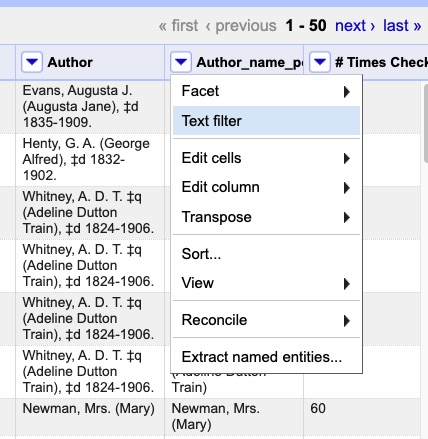

Then I typed an open parenthesis into the filter to return the 78 rows that matched my criterion.

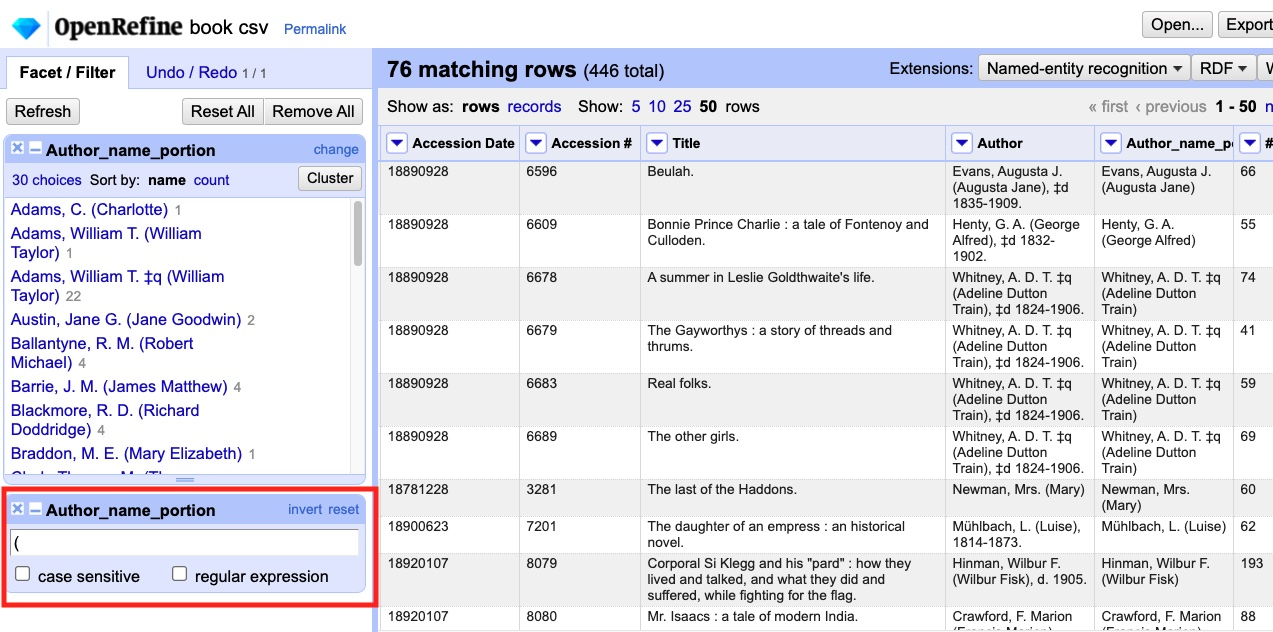

With just those cells visible, I clicked the triangle at the top of the column and chose "Edit cells", then "Transform..."

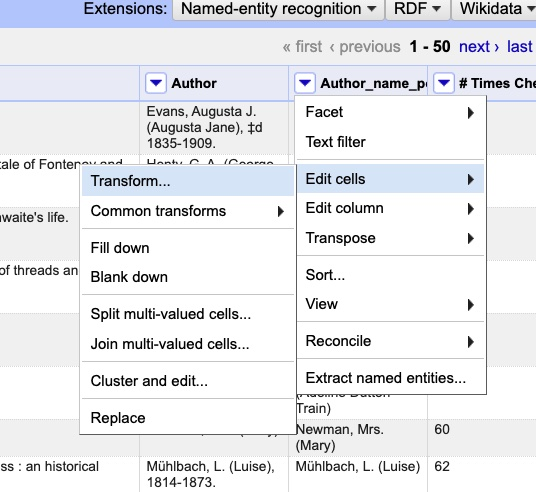

This *definitely* seemed like a job for regular expressions, so I imported the `re` package and constructed a regular expression to search for that takes advantage of what are called "capture groups": patterns that we don't simply match, but match and save so that they can be re-used.

This is the formula I used, which is a little involved:

```
import re
fuller_form = re.compile(r'^(.+),\s(.+)\((.+)\)')
fuller_capture = re.search(fuller_form, value)
return fuller_capture.group(1) + ', ' + fuller_capture.group(3)
```

I first defined compiled a regular expression to search for:

>`^(.+),\s(.+)\((.+)\)

Reading from left to right: 

* The caret indicates that I want to start at the beginning of the string (this wasn't strictly necessary, but ensured that I would only be matching patterns that took in the whole string).
* `(.+),` defines the first "capture group" (that's what the parentheses are doing), which simply consists of one or more characters of any kind. The comma comes next, which falls outside of the capture group: stop just short of the comma. This pattern should capture last names.
* `\s` indicates a white space character
* `(.+)\(` represents a second capture group of one or more characters of any type. This time I've indicated that the capture group should come before an open parenthesis. The backslash in front of the open parenthesis serves to "escape" the parenthesis—that is, to treat it literally as an open parenthesis character, rather than parse it according to the special meaning of parentheses in regular expressions (which, as we've seen, is to define capture groups. So this group captures the portion after the last name and up to the form within parentheses.
* `(.+)\)` represents the final capture group: again, one or more of any character, followed by a closed parenthesis (also escaped, as above). This should capture the text inside the parentheses.

`fuller_capture` is a variable that represents the *result* of searching for the `fuller_form` pattern in `value`.

The formula then returns the contents of the first capture group (i.e., the last name), followed by a comma and a space, and then the contents of the final capture group. (I could have reversed the order of first name and last name, but I figured I'd do that in a later step when I could take care of all the names at once.)

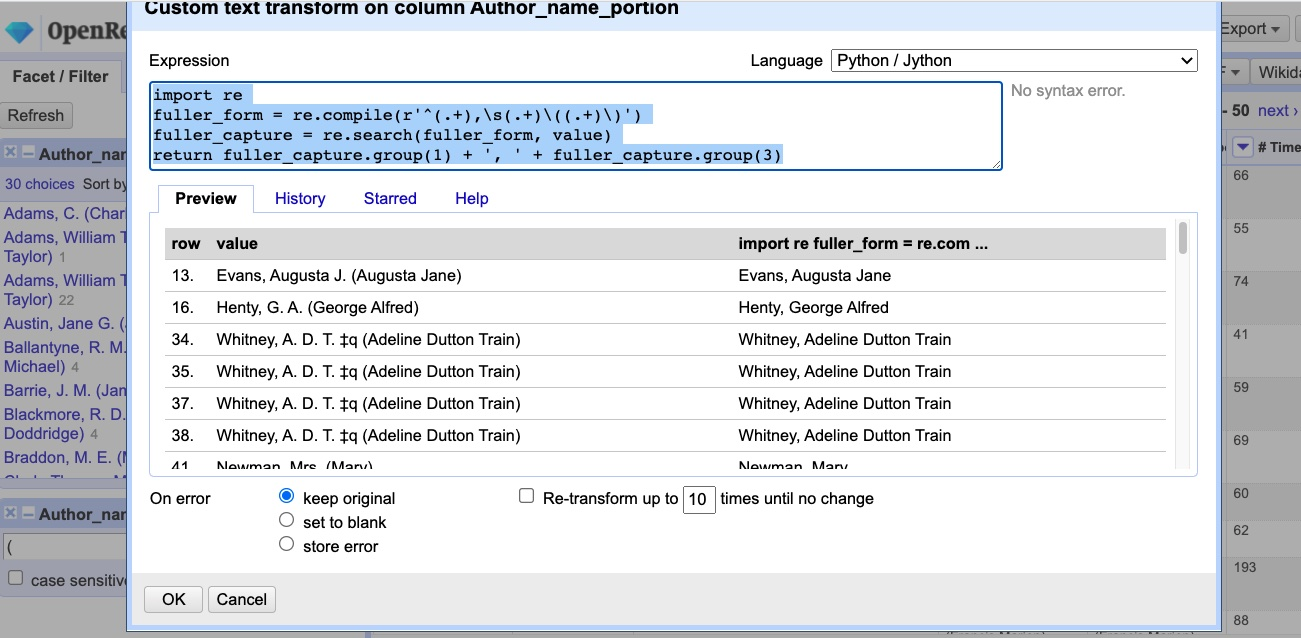

After accepting those changes, the screen went blank because there were no longer any rows that match the text filter condition, so I needed to click "reset" on the Text filter and begin looking for my next case to fix. 

This really seemed to have handled pretty much all of the rows, but there were some that weren't in a straightforward lastname, firstname format. I noticed, for instance, `Lytton, Edward Bulwer Lytton,  Baron` and `Bethusy-Huc, Valeska, Gräfin von`, for instance. So the presence of more than one comma seemed like the next condition to use in my text filter. 

OpenRefine allows us to search using regular expressions, so I checked that box and searched for teh pattern: `.+,\s.+,` (that is, one or more characters, followed by a comma and a space, then one or more characters followed by another comma). This returned 25 rows.

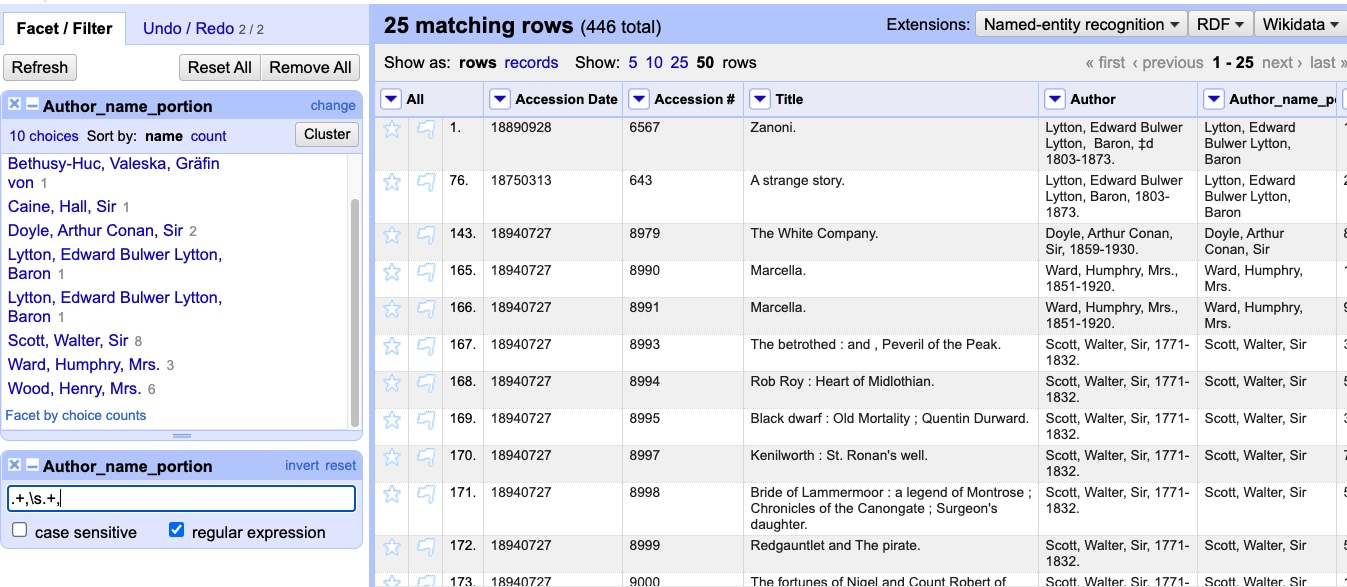

So, once more, "Edit cells > Transform..." This time, I decided to split the value into a list, using the comma as the separator. So, `Lytton, Edward Bulwer Lytton, Baron` would become `['Lytton', 'Edward Bulwer Lytton', 'Baron']` and `Doyle, Arthur Conan, Sir` would become `['Doyle', 'Arthur Conan', Sir']`. This worked well for most of my names, but not names with aristocrativ titles. I went ahead and accepted the changes, figuring I could use my text facets to come back to the problematic cases.

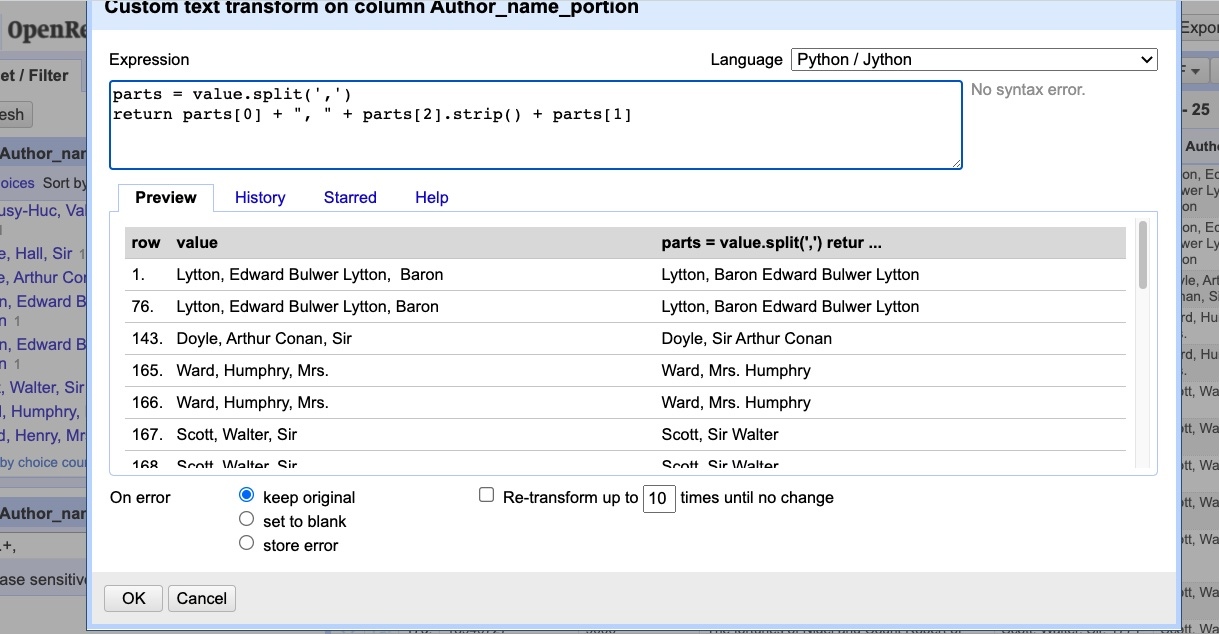

I reset the text filter again, then used the Text facets to select names that I could see had been problematic in my last step. It turns out that there were only three rows that fit the bill.

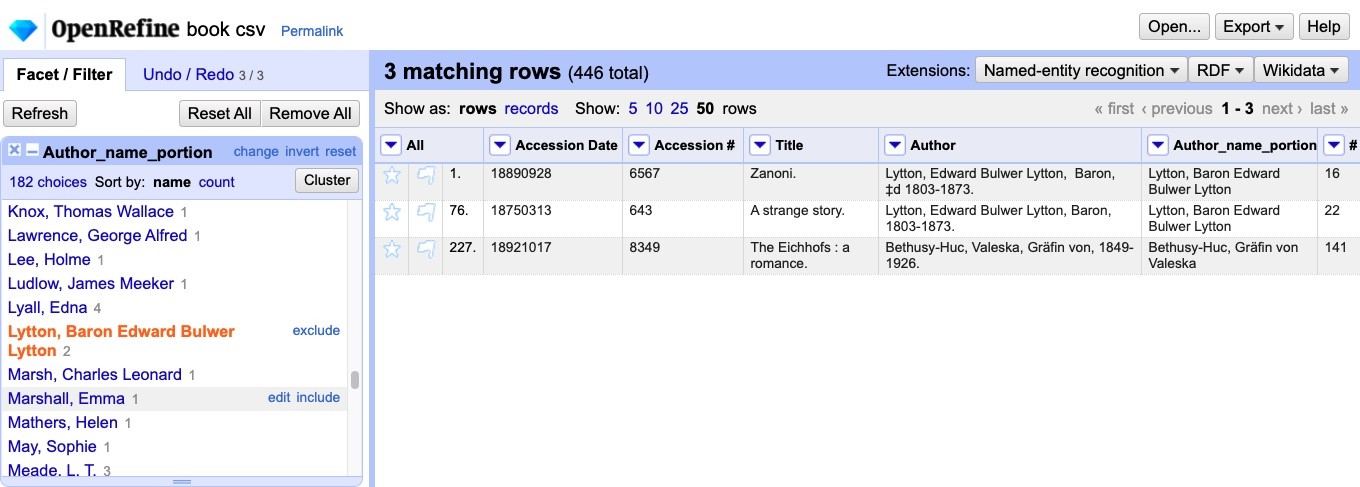

Since there were so few, I simply hovered over the cell until the "edit" link appeared, clicked it, and edited the cells by hand. In the case of Bulwer Lytton, I could at least apply the transformation to all identical cells. Which was two of them. 

(Because I was going ahead and reordering the names for these three celss, I needed to be sure to *exclude* those names in the list of text facets so that I wouldn't re-transform them when I bulk-edited the rest of the cells to put first names before last names. I selected the two text facets, then clicked "invert" at the top of the Text facet pane.)

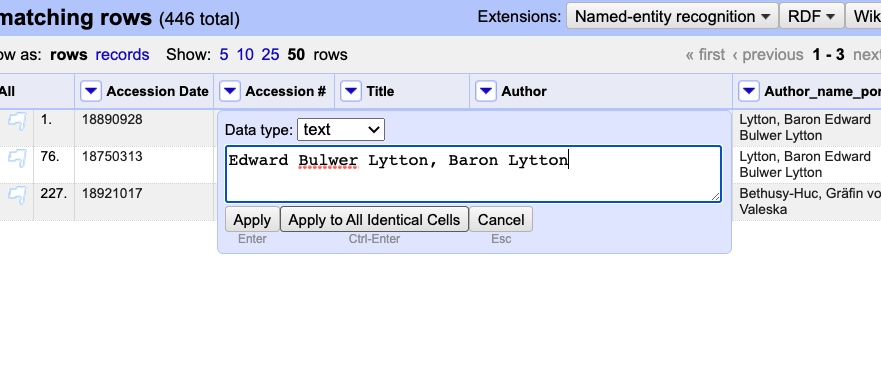

From here, the last thing I saw that could be fixed before flipping all the first and last names was that there were a few entries that had stray periods at the end of the first name. But while I wanted to fix, for example, `Cobden, Paul.`, a name like `Clay, Bertha M.` didn't need changing. Rather than trying to use a regular expression here, I used the text filter field and searched for a regular expression of a field ending in a period: `\.$`

Because OpenRefine allows you to edit cells right from the text facet list, I could make short work of the 17 names that fit this pattern, changing `Barrili, Anton Giulio.`, but leaving `Alexander, Mrs.` alone. (I took this opportunity to fix the real outlier of `Duchess, 1855?-1897.`, while I was at it.)

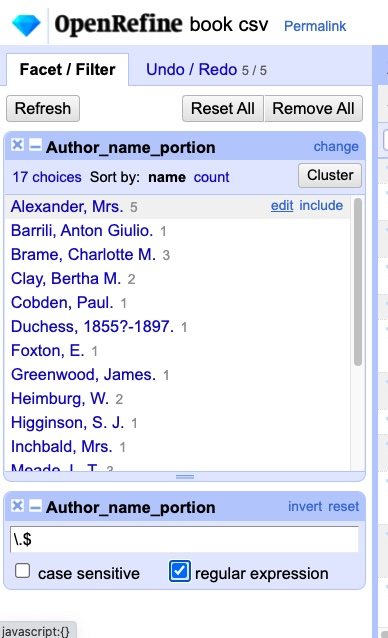

With that done, it was time to turn all of my lastname, firstname fields into firstname, lastname. So, again, "Edit cells > Transform..." 

I opted to split the value into a list on the comma again and reassemble the parts of the list in reverse order: 

```
parts = value.split(',')
return parts[1] + " " + parts[0]
```

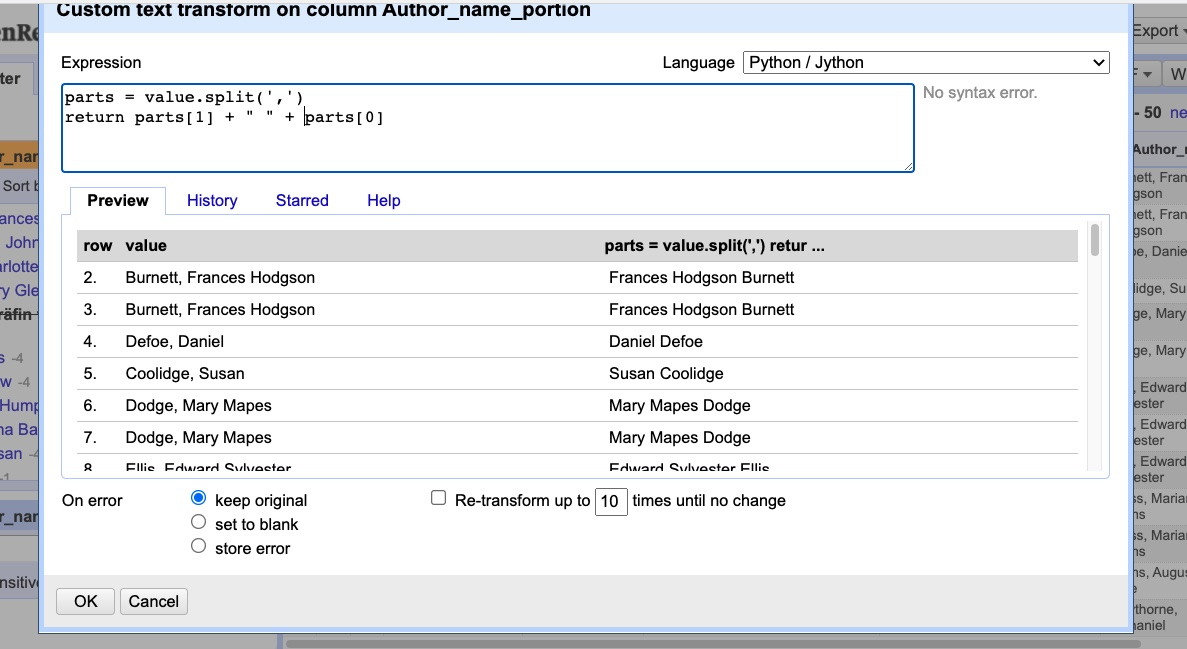

At this point, I was done (this would only have taken a few minutes if I hadn't been documenting the process), so I cleared all of the filters (that were, at this point, excluding Edward Bulwer Lytton, Baron Lytton and Vareska, Gräfin von Bethusy-Huc) and exported the project as a .csv file, which I put in the `wmr_full_search_results` folder.

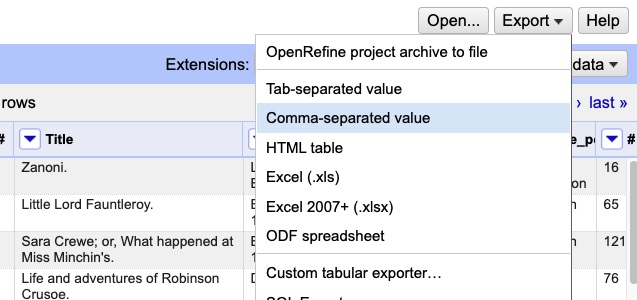

## 4 - Next steps
Now that we have the WMR data (including links back to the site) and have transformed the author field in the `book.csv` file, you can decide how you want to prepare you list of nodes and edges: either using Google Sheets or using Python code. Move on to the next notebook for those steps.